In [15]:
import torch, pickle, argparse, os
import importlib
from fig_settings import *
from util import *
from torch.utils.data import DataLoader, random_split, Subset, ConcatDataset
import numpy as np

In [185]:
import numpy as np 
from scipy.integrate import simpson
from scipy.linalg import eigh
import math


def _flip(angles, index):
    for ii in range(index.shape[0]):
        if ii % 2 == 0:
            angles[index[ii, 0]:index[ii + 1, 0], index[ii, 1]] = math.pi - angles[index[ii, 0]:index[ii + 1, 0],
                                                                            index[ii, 1]]
    return angles


class memory_kernel_homogenized_model:
    def __init__(self, viscous=None, elastic=None, kernel=None, T=1.0):
        self._nu_p = viscous
        self._E_p = elastic
        self._kernel = kernel
        self._t = np.linspace(0.0, T, kernel.shape[0])
        self._dt = np.mean(self._t[1:] - self._t[:-1])

    def predict(self, ebar, rate):
        if isinstance(ebar, np.ndarray) and isinstance(ebar, np.ndarray):
            ebar_array = ebar
            rate_array = rate
        else:
            ebar_array = ebar(self._t)
            rate_array = rate(self._t)
        stress = np.zeros((self._t.size, self._nu_p.shape[0]))
        # stress[0] = self._nu_p @ rate_array[0]
        for ii, time in enumerate(self._t[1:]):
            step = ii + 1
            # stress[step] = self._nu_p @ rate_array[step] + self._E_p @ ebar_array[step]
            kernel_flip = np.flip(-self._kernel[:step + 1], 0)
            integrand = np.einsum("ijk, ik -> ij", kernel_flip, ebar_array[:step + 1])
            stress[step] += simpson(integrand, dx=self._dt, axis=0)
        return self._t, stress

    def eigen(self, type=None):
        if type == "viscous":
            s, basis = eigh(self._nu_p)
            angles = np.arccos(np.diagonal(np.abs(basis)))
            return s, angles
        elif type == "elastic":
            s, basis = eigh(self._E_p)
            angles = np.arccos(np.diagonal(np.abs(basis)))
            return s, angles
        elif type == "kernel":
            angles = np.zeros((self.nt+1, 3))
            s = np.zeros((self.nt+1, 3))
            for ii, time in enumerate(self._t):
                s[ii], basis = eigh(self._kernel[ii])
                angles[ii] = np.arccos(np.diagonal(np.abs(basis)))
            index = self._check_for_reflection(angles)
            angles = _flip(angles, index)
            return s, angles
        else:
            raise Exception("Wrong type. Must be viscous, elastic or kernel.")

    def _check_for_reflection(self, angles):
        angels_1st_rate = np.gradient(angles, self.dt, axis=0, edge_order=2)
        angels_2nd_rate = np.gradient(angels_1st_rate, self.dt, axis=0, edge_order=2)
        index = np.vstack(
            np.where(np.abs(angels_2nd_rate - np.mean(angels_2nd_rate, axis=0)) > 5 * np.std(angels_2nd_rate))).T[1::3]
        unique, count = np.unique(index[:, 1], return_counts=True)
        for ii, id in enumerate(unique):
            if count[ii] % 2 != 0:
                index = np.vstack((index, np.array([0, id])))
        for ii in range(2):
            index = index[index[:, ii].argsort()]
        return index

    @property
    def viscous(self):
        return self._nu_p

    @property
    def elastic(self):
        return self._E_p

    @property
    def kernel(self):
        return self._kernel

    @property
    def T(self):
        return self._t[-1]

    @property
    def dt(self):
        return self._dt

    @property
    def nt(self):
        return self._t.size-1

    @property
    def times(self):
        return self._t

In [715]:
run_id = 'material_model_run_n13' 
''

CKPT_PATH = run_id+ '/vmm-epoch=1999-train_rel_error=0.0000.ckpt'
checkpoint = torch.load(CKPT_PATH, map_location='cpu')

/var/folders/sw/6bcl4ngj0x77mrv5p1s62_k00000gn/T/ipykernel_2965/3244481286.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(CKPT_PATH, map_locatio

In [716]:
params = torch.load(run_id+'/args.pkl', weights_only=True)
args = argparse.Namespace(**params)  
folder = f'overleaf/figs/{run_id}' 
if not os.path.exists(folder):
    os.makedirs(folder)

In [753]:
mm = importlib.import_module(run_id + '.' + args.material_model)
from util import LossFunction
from m_encoder import *
from lightning_script import *
device = torch.device(args.device if torch.cuda.is_available() else "cpu")

In [754]:
encoder_input_dim = 501
ae_E = AutoEncoder(
            encoder_input_dim, args.encoder_hidden_dim, args.encoder_latent_dim
        ).to(device)
ae_nu = AutoEncoder(
            encoder_input_dim, args.encoder_hidden_dim, args.encoder_latent_dim
        ).to(device)
energy_input_dim = (1, args.niv, args.encoder_latent_dim * 2)
energy_hidden_dim = list(
        map(lambda l: int(l.strip()), args.hidden_dim.strip().split(","))
    )
dissipation_input_dim = energy_input_dim  # (p_dim, q_dim, m_dim)
dissipation_hidden_dim = list(
        map(lambda l: int(l.strip()), args.hidden_dim.strip().split(",")))
ae_E.freeze_encoder()
ae_nu.freeze_encoder()

vmm = mm.ViscoelasticMaterialModel(
    energy_input_dim,
    energy_hidden_dim,
    dissipation_input_dim,
    dissipation_hidden_dim,
    ae_E.encoder,
    ae_nu.encoder,
    dt = args.step/5000.0
).to(device)

In [719]:
lit = LitVMM.load_from_checkpoint(checkpoint_path=CKPT_PATH, model=vmm, name="vmm_", loss_type="mse")

In [590]:
device = torch.device(args.device if torch.cuda.is_available() else "cpu")

data_file = args.data_path
content = open(data_file, "r").read().strip()
data_files = [file.strip() for file in content.split("\n")]
# data_files = [file.strip() for file in data_file.split(",")]
# print(data_files)

datasets = [
    ViscoelasticDataset(
        data_path=file,
        step=args.step,
        device=device,
        encoder=False,
    )
    for file in data_files
]
dataset = ConcatDataset(datasets)
length = len(dataset)

trainset = Subset(dataset, args.train_indices)
valset = Subset(dataset, args.val_indices)
testset = Subset(dataset, args.test_indices)
loss_function = LossFunction()

In [544]:
tempset = trainset
indices = args.train_indices

In [520]:
data0 = pickle.load(open(data_files[0], 'rb'))
data1 = pickle.load(open(data_files[1], 'rb'))
data2 = pickle.load(open(data_files[2], 'rb'))
data3 = pickle.load(open(data_files[3], 'rb'))
data_map = {0: data0, 1: data1, 2: data2, 3: data3}

relevant_cols = ['strain', 'strain_rate', 'stress', 'E', 'nu', 'E_prime', 'nu_prime', 'kernel']
data = {}
for col in relevant_cols:
    data[col] = []
    for i in range(4):
        data_i = data_map[i]
        if col in ['strain', 'strain_rate', 'stress', 'kernel']:
            data[col].append(data_i[col][:,::50]) 
        else:
            data[col].append(data_i[col])
    data[col] = np.concatenate(data[col], axis=0)


In [20]:
s_perd_new = s_pred - np.expand_dims(error_mean, axis=-1)
loss_function.L2RelativeError(s_perd_new, s_true), loss_function.L2RelativeError(s_pred, s_true)

(tensor(0.0204), tensor(0.0204))

In [116]:
E_features = vmm.E_encoder(torch.tensor(data['E'], dtype=torch.float32))
nu_features = vmm.E_encoder(torch.tensor(data['nu'], dtype=torch.float32))
m_features = torch.cat([E_features, nu_features], axis=1)
data['E_pred'] = vmm.energy_function.E0(m_features).detach().numpy()
data['nu_pred']= vmm.dissipation_potential.nu0(m_features).detach().numpy()
data['A_pred']= vmm.energy_function.A(m_features).detach().numpy()
data['BbyA_pred']= vmm.dissipation_potential.BbyA(m_features).detach().numpy()
data['B'] = data['A_pred'] * data['BbyA_pred']
x = (data['strain'], data['strain_rate'], data['E'], data['nu'])
x = map(lambda l: torch.tensor(l, dtype=torch.float32), (data['strain'], data['strain_rate'], data['E'], data['nu']))
data['s_pred'], data['xi_pred'] =  vmm(*x)
data['kernel_pred'] = np.zeros_like(data['kernel'])

In [117]:
hom_model = memory_kernel_homogenized_model(viscous=data['nu_prime'][0], elastic=data['E_prime'][0], kernel=data['kernel'][0])
hom_model1 = memory_kernel_homogenized_model(viscous=data['nu_pred'][0], elastic=data['E_pred'][0], kernel=data['kernel_pred'][0])

In [118]:
t, s = hom_model.predict(data['strain'][0], data['strain_rate'][0])
t, s1 = hom_model1.predict(data['strain'][0], data['strain_rate'][0])

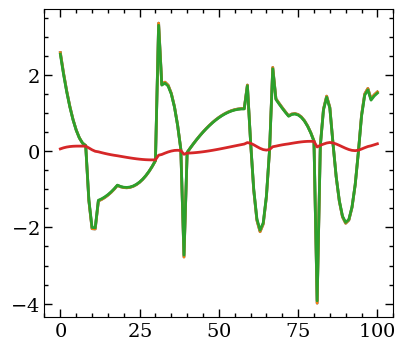

In [119]:
plt.plot(s), plt.plot(data['stress'][0]), plt.plot(data['s_pred'][0].detach().numpy()), plt.plot(s1)
plt.show()

In [387]:
mm = importlib.import_module('m_dependent_b_true')
mm = importlib.reload(mm)

In [388]:
model = mm.ViscoelasticMaterialModel(
    energy_input_dim = (1, 1, 30),
    energy_hidden_dim = [100],
    dissipation_input_dim = (1, 1, 30),
    dissipation_hidden_dim = [100], 
    E_encoder = ae_E.encoder,
    nu_encoder = ae_nu.encoder,
    dt = 50/5000.0
)

In [672]:
e = torch.tensor(data['strain'][[0]], dtype=torch.float32)
e_dot = torch.tensor(data['strain_rate'][[0]], dtype=torch.float32)
E = torch.tensor(data['E'][[0]], dtype=torch.float32)
nu = torch.tensor(data['nu'][[0]], dtype=torch.float32)
time = torch.linspace(0, 1, 101, dtype=torch.float32)
kernel = torch.exp(-2*time).reshape(-1, 1, 1)

In [700]:
s_pred, xi_pred = vmm(torch.tensor(data['strain'], dtype=torch.float32),
                        torch.tensor(data['strain_rate'], dtype=torch.float32),
                        torch.tensor(data['E'], dtype=torch.float32),
                        torch.tensor(data['nu'], dtype=torch.float32),
)
s_true = data['stress']

In [701]:
memory = loss_function.L2RelativeError(s_pred, torch.tensor(s_true, dtype=torch.float32), reduction=None)

In [702]:
np.mean(memory[indices].detach().numpy()), np.std(memory[indices].detach().numpy())

(0.019335985, 0.02083492)

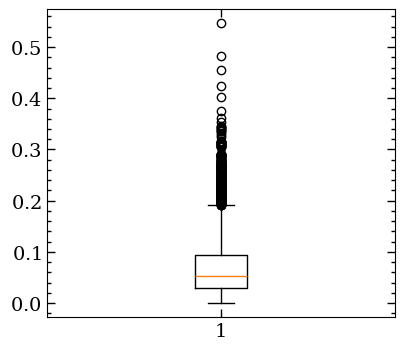

In [676]:
plt.boxplot(memory.detach().numpy())
plt.show()

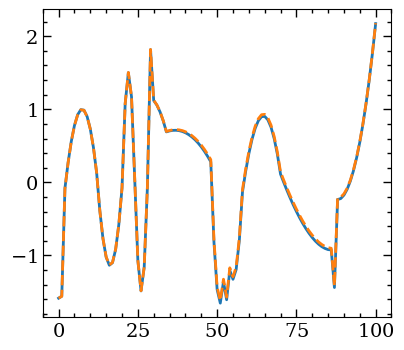

In [394]:
i = 100
plt.plot(s_true[i], '-')
plt.plot(s_pred[i].detach().numpy(), '--')
# plt.plot(lianghao_s, ':')

([<matplotlib.lines.Line2D at 0x37485a450>],
 [<matplotlib.lines.Line2D at 0x37485a930>])

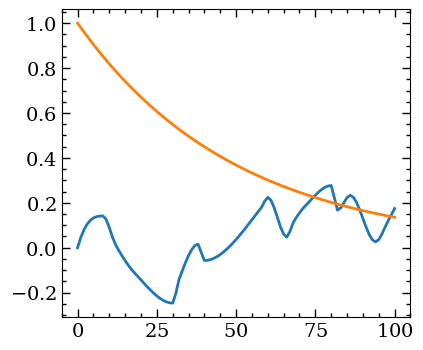

In [215]:
plt.plot(e.numpy()[0,:,0]), plt.plot(kernel[:,0,0])

In [313]:
data['E'].shape

(4000, 501)

In [315]:
tf = TrueFeatures()
E_prime, nu_prime = tf(torch.tensor(data['E'], dtype=torch.float32), torch.tensor(data['nu'], dtype=torch.float32))


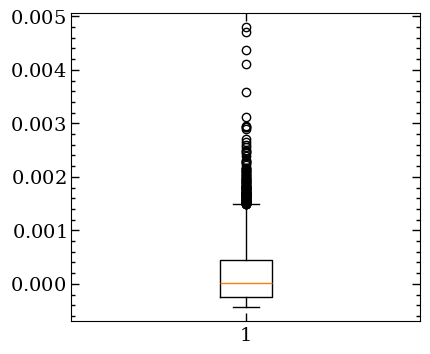

In [333]:
plt.boxplot(data['nu_prime'][:,:,0] -nu_prime.detach().numpy())
plt.show()

In [416]:
encoder = importlib.import_module('m_encoder')
encoder = importlib.reload(encoder)

In [417]:
je = encoder.JointAutoEncoder([501, 2], 100, 15)

In [431]:
E, nu = torch.tensor(data['E'], dtype=torch.float32), torch.tensor(data['nu'], dtype=torch.float32)
optimizer = torch.optim.Adam(je.parameters(), lr=1e-3)

In [451]:
for e in range(1000):
    E_pred, nu_pred = je(E, nu)
    loss = torch.nn.functional.mse_loss(E_pred, E) + torch.nn.functional.mse_loss(nu_pred, nu)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    if e % 100 == 0:
        print(f'Epoch {e}, Loss: {loss.item()}')

Epoch 0, Loss: 0.09384319186210632
Epoch 100, Loss: 0.09348268806934357
Epoch 200, Loss: 0.09319604933261871
Epoch 300, Loss: 0.09301100671291351
Epoch 400, Loss: 0.09285037219524384
Epoch 500, Loss: 0.09260983765125275
Epoch 600, Loss: 0.09295984357595444
Epoch 700, Loss: 0.09212803840637207
Epoch 800, Loss: 0.0920233428478241
Epoch 900, Loss: 0.09148409217596054


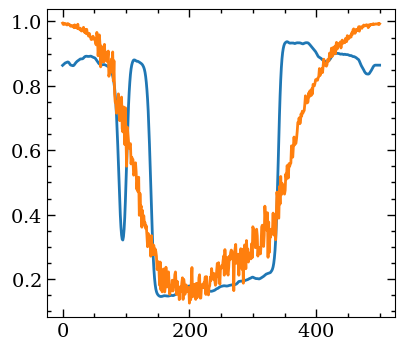

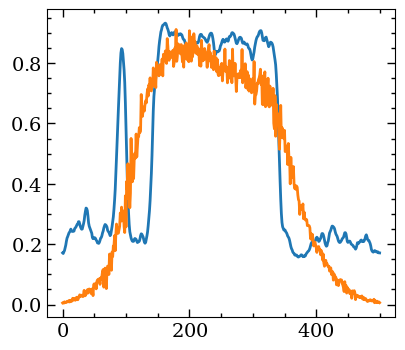

In [453]:
i = 41
plt.plot(E.numpy()[i,:])
plt.plot(E_pred.detach().numpy()[i,:])
# plt.plot(nu.numpy()[i,:])
plt.show()
plt.plot(nu.numpy()[i,:])
plt.plot(nu_pred.detach().numpy()[i,:])

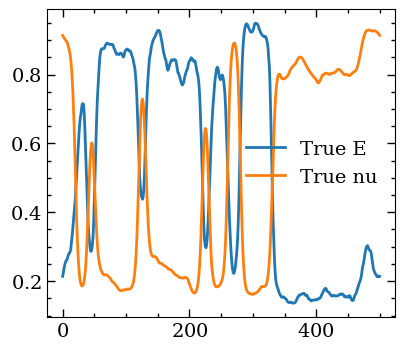

In [457]:
i = 11
plt.plot(E.numpy()[i,:], label
         ='True E')
plt.plot(nu.numpy()[i,:], label='True nu')
plt.legend()



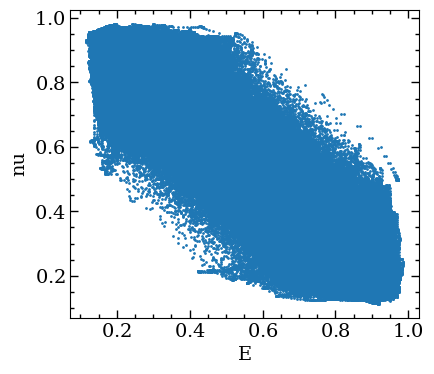

In [461]:
plt.scatter(E.numpy().flatten(), nu.numpy().flatten(), s=1)
plt.ylabel('nu')
plt.xlabel('E')
plt.show()

In [467]:
e0 = data['E_prime'].squeeze() - 1

{'whiskers': [<matplotlib.lines.Line2D at 0x3d1bac4a0>,
 'caps': [<matplotlib.lines.Line2D at 0x3d16ffc20>,
 'boxes': [<matplotlib.lines.Line2D at 0x3d1bac170>],
 'medians': [<matplotlib.lines.Line2D at 0x3d1b6fec0>],
 'fliers': [<matplotlib.lines.Line2D at 0x3d1b6fda0>],
 'means': []}

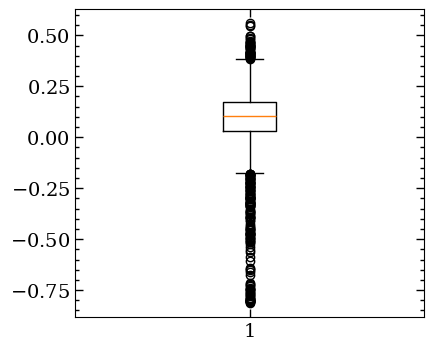

In [469]:
plt.boxplot(e0.flatten())

array([[1.        , 0.08029475],
       [0.08029475, 1.        ]])

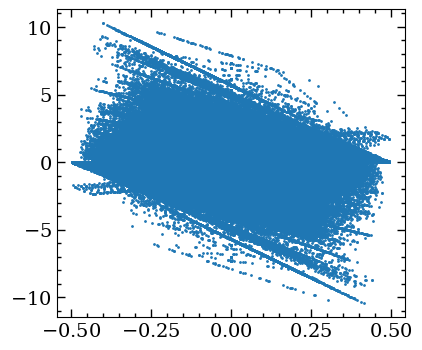

In [582]:
plt.scatter(data['strain'].flatten(), data['strain_rate'].flatten(), s=1)
np.corrcoef(data['strain'].flatten(), data['strain_rate'].flatten())

In [595]:
# B_ref = vmm.energy_function.B(m_features).detach().numpy()
# beta_ref = vmm.dissipation_potential.beta(m_features).detach().numpy()

In [720]:
m_features = vmm.microstructure_encoder(torch.tensor(data['E'], dtype=torch.float32), torch.tensor(data['nu'], dtype=torch.float32))
E_prime, nu_prime, m_features = torch.split(m_features, [1, 1, 30], -1)
E_prime = E_prime.numpy()
B = vmm.energy_function.B(m_features).detach().numpy()
beta = vmm.dissipation_potential.beta(m_features).detach().numpy()
B_error = B_ref - B
beta_error = beta_ref - beta

In [664]:
np.mean(beta_ref), np.std(beta_ref)

(0.84900784, 0.34150586)

In [665]:
np.mean(B_error.flatten()), np.std(B_error.flatten()), np.mean(beta_error.flatten()), np.std(beta_error.flatten())

(-0.6573182, 1.1846656, -0.17861125, 0.3293272)

In [722]:
E_pred = vmm.energy_function.E(m_features).detach().numpy()
nu_pred = vmm.dissipation_potential.nu0(m_features).detach().numpy()

In [ ]:
error_E = E_prime- E_pred
error_nu = (nu_prime - nu_pred).detach().numpy()

In [578]:
np.mean(error_E.flatten()), np.std(error_E.flatten()), np.mean(error_nu.flatten()), np.std(error_nu.flatten())

(0.74700296, 0.36678752, 0.005096141, 0.027613824)

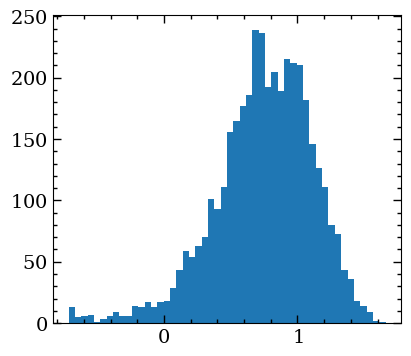

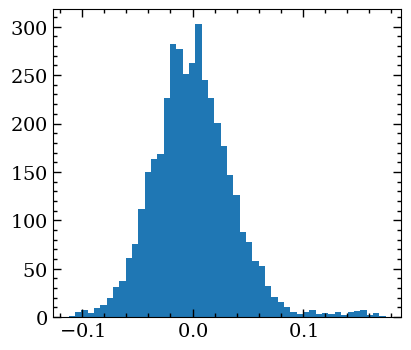

In [573]:
plt.hist(error_E.flatten(), bins=50)
plt.show()
plt.hist(error_nu.flatten(), bins=50)
plt.show()

In [579]:
data['strain'].shape, data['strain_rate'].shape

((4000, 101, 1), (4000, 101, 1))

In [626]:
beta_ref.shape, B_ref.shape

((4000, 1), (4000, 1))

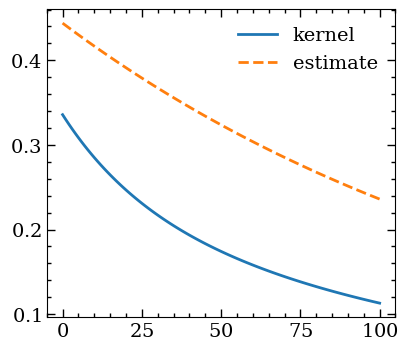

In [688]:
i = 120
kernel = data['kernel'][i].squeeze()
time = np.linspace(0, 1, kernel.shape[0])
alpha = kernel[0]
kernel_estimate = beta[i,0] * np.exp(-(B[i,0] + 1)*beta[i,0] * time)
plt.plot(kernel, label='kernel')
plt.plot(kernel_estimate, '--', label='estimate')
plt.legend()
plt.show()

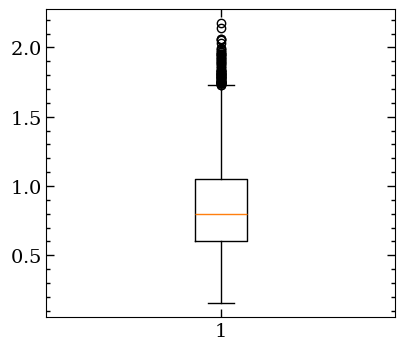

In [709]:
plt.boxplot(beta)
plt.show()

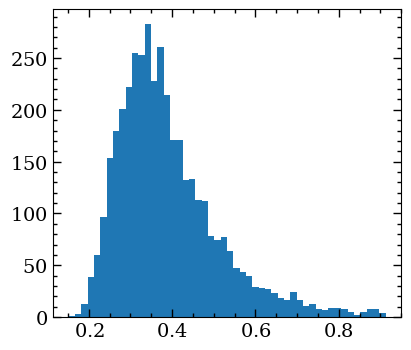

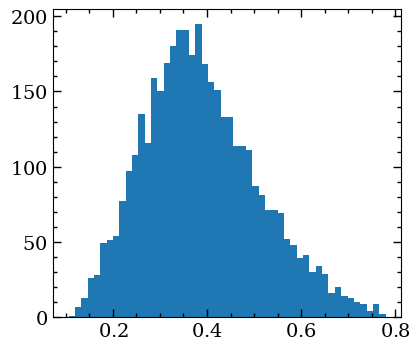

In [724]:
plt.hist(data['nu_prime'].squeeze().flatten(), bins=50)
plt.show()
plt.hist(nu_pred.squeeze().flatten(), bins=50)
plt.show()

In [729]:
import glob

In [769]:
file = glob.glob('material_model_run_n4/vmm-*.ckpt')[0]

In [770]:
data = torch.load(file , map_location='cpu', weights_only=False)

In [771]:
data['state_dict'].keys()

odict_keys(['model.energy_function.B.0.weight', 'model.energy_function.B.0.bias', 'model.energy_function.B.2.weight', 'model.energy_function.B.2.bias', 'model.dissipation_potential.beta.0.weight', 'model.dissipation_potential.beta.0.bias', 'model.dissipation_potential.beta.2.weight', 'model.dissipation_potential.beta.2.bias', 'model.E_encoder.0.weight', 'model.E_encoder.0.bias', 'model.E_encoder.2.weight', 'model.E_encoder.2.bias', 'model.E_encoder.4.weight', 'model.E_encoder.4.bias', 'model.nu_encoder.0.weight', 'model.nu_encoder.0.bias', 'model.nu_encoder.2.weight', 'model.nu_encoder.2.bias', 'model.nu_encoder.4.weight', 'model.nu_encoder.4.bias'])

In [764]:
ae_E.load_state_dict(data['state_dict'])

RuntimeError: Error(s) in loading state_dict for AutoEncoder:
	Missing key(s) in state_dict: "encoder.0.weight", "encoder.0.bias", "encoder.2.weight", "encoder.2.bias", "encoder.4.weight", "encoder.4.bias", "decoder.0.weight", "decoder.0.bias", "decoder.2.weight", "decoder.2.bias", "decoder.4.weight", "decoder.4.bias". 
	Unexpected key(s) in state_dict: "model.encoder.0.weight", "model.encoder.0.bias", "model.encoder.2.weight", "model.encoder.2.bias", "model.encoder.4.weight", "model.encoder.4.bias", "model.decoder.0.weight", "model.decoder.0.bias", "model.decoder.2.weight", "model.decoder.2.bias", "model.decoder.4.weight", "model.decoder.4.bias". 